In [1]:
import io
from itertools import groupby
from itertools import cycle
import math
import os
from pathlib import Path
from sys import stderr
import sys
from time import sleep, perf_counter as timer

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

from resemblyzer.audio import sampling_rate
from resemblyzer import preprocess_wav, VoiceEncoder

from umap import UMAP

from pydub import AudioSegment
from pydub.utils import make_chunks

import numpy as np

import mutagen
from mutagen.mp3 import MP3

import soundfile as sf

In [2]:
_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
], dtype=np.float) / 255

/tmp/ipykernel_122/3802033907.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ], dtype=np.float) / 255


In [3]:
INPUT_DIR = "audio/input/"
OUTPUT_DIR = "audio/output/"
PLOT = "plot/"
TIMESTAMP = "timestamp/"
INTERVAL = 3
TIMES = 1000

In [4]:
def get_audio_length(audio_data):

    audio = MP3(audio_data)
    audio_info = audio.info    
    length_in_secs = int(audio_info.length)
    return length_in_secs

def check_or_make_dir(audio_dir):

    if not os.path.isdir(audio_dir):
        os.makedirs(audio_dir)

def return_sound(sound, start):
    f = io.BytesIO()
    sound[start*TIMES:(start+INTERVAL)*TIMES].export(f, format='wav')
    f.seek(0)
    tmp = io.BytesIO(f.read())
    data, source_sr = sf.read(tmp)
    return data

def plot_projections(embeds, speakers, ax=None, colors=None, markers=None, legend=True, 
                     title="", **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
        
    # Compute the 2D projections. You could also project to another number of dimensions (e.g. 
    # for a 3D plot) or use a different different dimensionality reduction like PCA or TSNE.
    reducer = UMAP(**kwargs)
    projs = reducer.fit_transform(embeds)
    
    # Draw the projections
    speakers = np.array(speakers)
    colors = colors or _my_colors
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        marker = "o" if markers is None else markers[i]
        label = speaker if legend else None
        ax.scatter(*speaker_projs.T, c=[colors[i]], marker=marker, label=label)

    if legend:
        ax.legend(title="Speakers", ncol=2)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    
    print(projs)
    return projs

def get_min_index(cluster_centers, all_data_set):

    index_list = []
    for center in cluster_centers:
        length_list = [math.sqrt((center[0]-x[0])**2 + (center[1]-x[1])**2) for x in all_data_set]
        min_length = min(length_list)
        min_index = length_list.index(min_length)
        print(all_data_set[min_index])
        print(min_index)
        index_list.append(min_index)
    return sorted(index_list)

"-----------------------------------------------------------------------------------"

def group(L):
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

def separate_continuous_sound(speaker_wav_dict_list):
    new_dict = {}
    neo_new_dict = []
    for speaker_wav_dict in speaker_wav_dict_list:
        for speaker, wav_list in speaker_wav_dict.items():
            new_dict[speaker] = list(group(wav_list))
    for speaker, wav_list in new_dict.items():
        neo_new_dict.extend( [({'group':[w for w in wav], 'speaker':speaker}) 
                              for wav in[wav for wav in wav_list if wav[1] - wav[0] >2]])
        
    neo_new_dict = sorted(neo_new_dict, key=lambda key: key['group'][0])
    return neo_new_dict

def consolidate_continuous_speaker(data_dict):
    
    neo_new_dict_second = {}
    current_speaker = -1
    index = 0
    for data in data_dict:
        if current_speaker == -1:
            current_speaker = data['speaker']
            neo_new_dict_second[index] = data
        elif current_speaker == data['speaker']:
            neo_new_dict_second[index]['group'].extend(data['group'])
        elif current_speaker != data['speaker']:
            index += 1
            current_speaker = data['speaker']
            neo_new_dict_second[index] = data
    
    neo_new_dict_second_list = [
        {'group': el['group'],
         'speaker': el['speaker'],
         'index': i} 
        for i, el in neo_new_dict_second.items()]
    neo_new_dict_second_list = sorted(neo_new_dict_second_list, key=lambda key: key['speaker'])
    return neo_new_dict_second_list

def add_speaker_index(data_list):
    
    index = 0
    current_speaker = -1
    for neo_dict_second in data_list:
        if current_speaker == -1:
            neo_dict_second['speaker_index'] = index
            current_speaker = neo_dict_second['speaker']
        elif current_speaker == neo_dict_second['speaker']:
            index += 1
            neo_dict_second['speaker_index'] = index
        elif current_speaker != neo_dict_second['speaker']:
            index = 0
            neo_dict_second['speaker_index'] = index
            current_speaker = neo_dict_second['speaker']
    
    neo_new_dict_second_list = sorted(data_list, key=lambda key: key['index'])
    return neo_new_dict_second_list
        
def generate_sound_index_list(data_list):
    
    neo_new_dict = [
        {'group': [i for i in range(el['group'][0],el['group'][len(el['group'])-1]+2)] , 
         'speaker_index':el['speaker_index'], 
         'index': index,
         'speaker':el['speaker'],
         'len':el['group'][len(el['group'])-1] - el['group'][0]}
         for index, el in enumerate(data_list)]
    #neo_new_dict = [el for el in neo_new_dict if el['len']>=2]
    return neo_new_dict

def get_speaker_wav_path_dict(sound_index, speaker_wav_dict_list, wav_fpaths):

    speaker_wav_path_dict = {}
    for speaker_wav_dict in speaker_wav_dict_list:
        print(speaker_wav_dict['speaker'])
        file_name = f"{sound_index}-"\
                    f"{('00'+str(speaker_wav_dict['index']))[-3:]}-"\
                    f"{('0'+str(speaker_wav_dict['speaker']))[-2:]}-"\
                    f"{('00'+str(speaker_wav_dict['speaker_index']))[-3:]}"
        print(len(wav_fpaths))
        print(speaker_wav_dict['group'][-1])
        if len(wav_fpaths) == speaker_wav_dict['group'][-1]:
            speaker_wav_dict['group'] = speaker_wav_dict['group'][:-1]
        speaker_wav_path_dict[file_name] = [ wav_fpaths[i] for i in speaker_wav_dict['group'] ]
    return speaker_wav_path_dict
        
def merge_and_save_sound(audio_dir, speaker_wav_path_dict):
    
    merge_sound = AudioSegment.empty()
    for speaker, sound_list in speaker_wav_path_dict.items():
        print(speaker)
        for sound in sound_list:
            print(type(sound))
            merge_sound += sound
        merge_sound.export(f"{OUTPUT_DIR}{audio_dir}{speaker}.wav", format="wav")
        merge_sound = AudioSegment.empty()


In [5]:
def get_processed_sound(input_audio):

    sound = AudioSegment.from_file(input_audio)
    sound = sound.set_channels(1)
    sound = sound.set_frame_rate(16000)
    return sound

def get_sound_list(sound, begin, end):

    sound_list = [ sound[start*TIMES:(start+INTERVAL)*TIMES ] for start in range(begin, end, INTERVAL)]
    return sound_list

def get_sound_feature_matrix(sound_list):

    temp_list = [ 
            np.array(each_sound.get_array_of_samples()).astype(np.float32)
            for each_sound in sound_list
        ]
    wav_list = [ y / (1 << 8*2 - 1) for y in temp_list ]
    wavs = np.array([ preprocess_wav(wav) for wav in wav_list ])
    return wavs

def get_utterance_embeds(wavs):

    encoder = VoiceEncoder()
    utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))
    return utterance_embeds

def create_pipeline(list_functions):

    def pipeline(input):
        res = input
        for function in list_functions:
            res = function(res)
        return res
    return pipeline

{0: (0, 1893)}


/tmp/ipykernel_122/244945664.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wavs = np.array([ preprocess_wav(wav) for wav in wav_list ])


Loaded the voice encoder model on cpu in 0.05 seconds.
[[-7.5415025  1.36123  ]
 [-7.467639   1.2878433]
 [-7.535254   1.356107 ]
 ...
 [-7.874132   1.6739159]
 [-7.9184494  1.7176081]
 [-8.041493   1.838533 ]]
[17.187262  9.943706]
532
[10.514986 -3.803155]
397
[  1.98168  -10.416024]
82
[-1.0902438 14.870064 ]
575
[-7.785104   1.5919982]
168
[-2.7601178  2.314215 ]
13
[1.2009169 8.980365 ]
441
[ 9.73941   -1.8331009]
625
[-1.1309525  8.549859 ]
382
[ 0.40496802 -9.610519  ]
454
0
[220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 329, 330, 331, 33

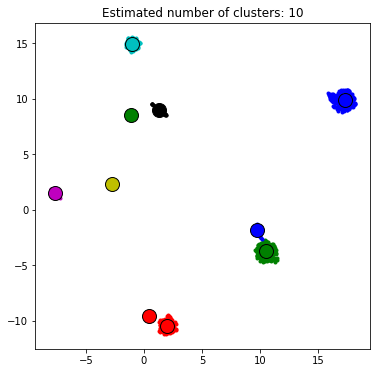

In [6]:
import json
audio_file = "20210916_1a_upload.mp3"
timestamp_json = f"{audio_file.split('.')[0]}.json"
audio_dir = f"{audio_file.split('.')[0]}/"
check_or_make_dir(f"{OUTPUT_DIR}{audio_dir}")
check_or_make_dir(f"{PLOT}{audio_dir}")
check_or_make_dir(f"{TIMESTAMP}")


input_audio = f"{INPUT_DIR}{audio_file}"

total_sound_length = get_audio_length(input_audio)
sound_length_list = [ length for length in range(0, total_sound_length, 3600)]
sound_length_set_list = {
    i:(
        length,
        sound_length_list[i+1] if i < len(sound_length_list)-1 else total_sound_length 
    )
    for i, length in enumerate(sound_length_list) }
print(sound_length_set_list)

timestamp_list = []
sound = get_processed_sound(input_audio)
for sound_index, partial_sound_len in sound_length_set_list.items():

    begin = partial_sound_len[0]
    end = partial_sound_len[1]

    sound_list = get_sound_list(sound, begin, end)
    wavs = get_sound_feature_matrix(sound_list)
    speakers = ['audio' for i in range(begin, end, INTERVAL)]
    utterance_embeds = get_utterance_embeds(wavs)

    X = plot_projections(utterance_embeds, speakers, title="Embedding projections")
    plt.savefig(f"{PLOT}{audio_dir}{sound_index}-plot_1.png")

    bandwidth = estimate_bandwidth(X, quantile=0.05, n_samples=len(speakers))

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    #print("number of estimated clusters : %d" % n_clusters_)

    index_list = get_min_index(cluster_centers, X)

    plt.figure(1)
    plt.clf()

    colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    index_list_set = []
    file_list_set = []
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        print(k)
        print([ index for index, val in enumerate(my_members) if val] )
        file_list_set.append({k: [ index for index, val in enumerate(my_members) if val]})
        index_list_set.extend([ (k, index) for index, val in enumerate(my_members) if val ])
        cluster_center = cluster_centers[k]
        plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=14)

    #print(file_list_set)
    index_list_set = sorted(index_list_set, key=lambda item: item[1])

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.savefig(f"{PLOT}{audio_dir}{sound_index}-plot_2.png")

    pipeline = create_pipeline([
        separate_continuous_sound,
        consolidate_continuous_speaker,
        add_speaker_index,
        generate_sound_index_list,
    ])

    sound_index_list = pipeline(file_list_set)
    timestamp_list.append(sound_index_list)
    with open(f"{TIMESTAMP}{timestamp_json}", "a") as r:
        r.write(json.dumps(sound_index_list))

    """
    for index in sound_index_list:
        print(index)
    speaker_wav_path_dict = get_speaker_wav_path_dict(sound_index, sound_index_list, sound_list)
    merge_and_save_sound(audio_dir, speaker_wav_path_dict)
    """

with open(f"{TIMESTAMP}{timestamp_json}", "w") as r:
        r.write(json.dumps(timestamp_list))